## PyMC3 Examples

# Robust Regression with Outlier Detection

@author: Jonathan Sedar  
@email: jon@sedar.co  
@date: Mon 21 Dec 2015  

**A minimal reproducable example of Robust Regression with Outlier Detection using Hogg 2010 Signal vs Noise method.**


+ We're using a simple linear OLS model with Normally distributed priors so that it behaves like a ridge regression
+ The model returns a robust estimate of linear coefficients and an indication of which datapoints (if any) are outliers.
+ The likelihood evaluation is essentially a copy of eqn 17 in "Data analysis recipes: Fitting a model to data" - [Hogg 2010](http://arxiv.org/abs/1008.4686)
+ The model is adapted specifically from Jake Van Der Plas' [implementation](http://www.astroml.org/book_figures/chapter8/fig_outlier_rejection.html) (3rd model tested)
+ The dataset is tiny and hardcoded into this Notebook. It contains errors in both the x and y, but we will deal here with only errors in y.


**Note:**
+ Python 3.3 project using latest available [PyMC3](https://github.com/pymc-devs/pymc3)
+ Developed using [ContinuumIO Anaconda](https://www.continuum.io/downloads) distribution on a Macbook Pro 3GHz i7, 16GB RAM, OSX 10.10.5.
+ If Theano throws weird errors, try clearing the cache `$> theano-cache clear` and rerunning the notebook.


**Package Requirements (shown as a conda-env YAML):**
```
$> less conda_env_pymc3_examples.yml

name: pymc3_examples
    channels:
      - defaults
    dependencies:
      - python=3.3
      - ipython
      - ipython-notebook
      - ipython-qtconsole
      - numpy
      - scipy
      - matplotlib
      - pandas
      - seaborn
      - pip

$> conda env create --file conda_env_pymc3_examples.yml

$> source activate pymc3_examples

$> pip install --process-dependency-links git+https://github.com/pymc-devs/pymc3

```

# Setup

In [1]:
%matplotlib inline
%qtconsole --colors=linux

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import optimize
import pymc3 as pm
import theano as thno
import theano.tensor as T 

# configure some basic options
sns.set(style="darkgrid", palette="muted")
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 12, 8
np.random.seed(0)

# Load and Prepare Data

We'll use the Hogg 2010 data available at  https://github.com/astroML/astroML/blob/master/astroML/datasets/hogg2010test.py

It's a very small dataset so for convenience, it's hardcoded below

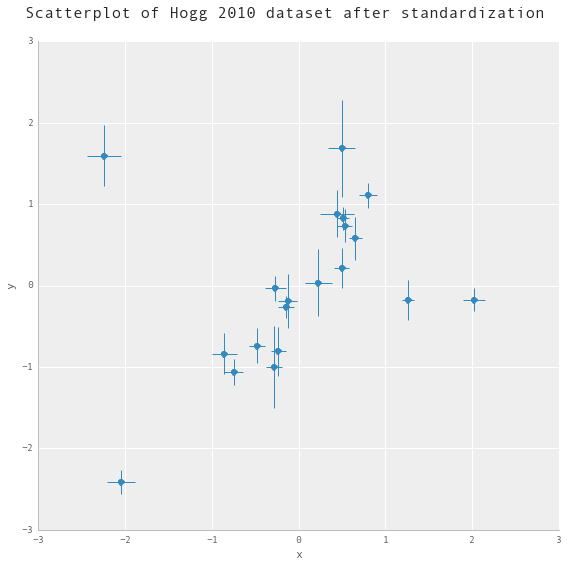

In [3]:
## cut & pasted directly from the fetch_hogg2010test() function
## identical to the original dataset as hardcoded in the Hogg 2010 paper

dfhogg = pd.DataFrame(np.array([[1, 201, 592, 61, 9, -0.84],
                                 [2, 244, 401, 25, 4, 0.31],
                                 [3, 47, 583, 38, 11, 0.64],
                                 [4, 287, 402, 15, 7, -0.27],
                                 [5, 203, 495, 21, 5, -0.33],
                                 [6, 58, 173, 15, 9, 0.67],
                                 [7, 210, 479, 27, 4, -0.02],
                                 [8, 202, 504, 14, 4, -0.05],
                                 [9, 198, 510, 30, 11, -0.84],
                                 [10, 158, 416, 16, 7, -0.69],
                                 [11, 165, 393, 14, 5, 0.30],
                                 [12, 201, 442, 25, 5, -0.46],
                                 [13, 157, 317, 52, 5, -0.03],
                                 [14, 131, 311, 16, 6, 0.50],
                                 [15, 166, 400, 34, 6, 0.73],
                                 [16, 160, 337, 31, 5, -0.52],
                                 [17, 186, 423, 42, 9, 0.90],
                                 [18, 125, 334, 26, 8, 0.40],
                                 [19, 218, 533, 16, 6, -0.78],
                                 [20, 146, 344, 22, 5, -0.56]])
                   ,columns=['id','x','y','sigma_y','sigma_x','rho_xy'])


## for convenience zero-base the 'id' and use as index
dfhogg['id'] = dfhogg['id'] -1
dfhogg.set_index('id', inplace=True)

## standardize (mean center and divide by 1 sd)
dfhoggs = (dfhogg[['x','y']] - dfhogg[['x','y']].mean(0)) / dfhogg[['x','y']].std(0)
dfhoggs['sigma_y'] = dfhogg['sigma_y'] / dfhogg['y'].std(0)
dfhoggs['sigma_x'] = dfhogg['sigma_x'] / dfhogg['x'].std(0)

## scatterplot the standardized data
g = sns.FacetGrid(dfhoggs, size=8)
_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='')
_ = g.axes[0][0].set_ylim((-3,3))
_ = g.axes[0][0].set_xlim((-3,3))

plt.subplots_adjust(top=0.92)
_ = g.fig.suptitle('Scatterplot of Hogg 2010 dataset after standardization', fontsize=16)

**Observe**:  

+ Even judging just by eye, you can see these datapoints mostly fall on / around a straight line with positive gradient
+ It looks like a few of the datapoints may be outliers from such a line

---

---

# Create and Run Conventional OLS Model

The *linear model* is really simple and conventional:

$$\bf{y} = \beta^{T} \bf{X} + \bf{\sigma}$$

where:  

$\beta$ = coefs = $\{1, \beta_{j \in X_{j}}\}$  
$\sigma$ = the measured error in $y$ in the dataset `sigma_y`

##### Define model

In [4]:
with pm.Model() as mdl_ols:
    
    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0_intercept', mu=0, sd=100)
    b1 = pm.Normal('b1_slope', mu=0, sd=100)
 
    ## Define linear model
    yest = b0 + b1 * dfhoggs['x']
    
    ## Use y error from dataset, convert into theano variable
    sigma_y = thno.shared(np.asarray(dfhoggs['sigma_y']
                            ,dtype=thno.config.floatX), name='sigma_y')

    ## Define Normal likelihood
    likelihood = pm.Normal('likelihood', mu=yest, sd=sigma_y**2, observed=dfhoggs['y'])


##### Sample

In [5]:
with mdl_ols:

    ## find MAP using Powell, seems to be more robust
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell, disp=True)

    ## take samples
    traces_ols = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True)

Optimization terminated successfully.
         Current function value: 4555.263214
         Iterations: 3
         Function evaluations: 104
 [-----------------100%-----------------] 2000 of 2000 complete in 0.7 sec

##### View Traces

**NOTE**: I'll 'burn' the traces to only retain the final 1000 samples

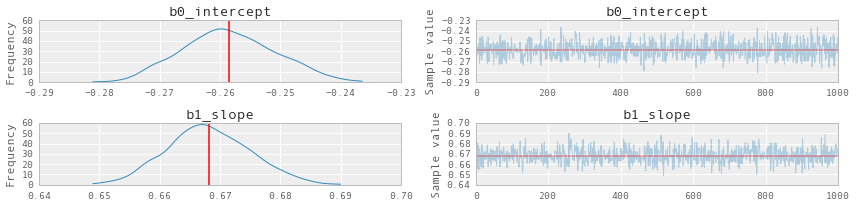

In [6]:
_ = pm.traceplot(traces_ols[-1000:], figsize=(12,len(traces_ols.varnames)*1.5)
                ,lines={k: v['mean'] for k, v in pm.df_summary(traces_ols[-1000:]).iterrows()})

---

---

# Create and Run Robust Model

Please read the paper (Hogg 2010) and Jake Van Der Plas' code for more complete information about the modelling technique.

The general idea is to create a 'mixture' model whereby datapoints can be described by either the linear model (inliers) or a modified linear model with different mean and larger variance (outliers).


The likelihood is evaluated over a mixture of two likelihoods, one for 'inliers', one for 'outliers'. A Bernouilli distribution is used to randomly assign datapoints in N to either the inlier or outlier groups, and we sample the model as usual to infer robust model parameters and inlier / outlier flags:

$$
\mathcal{logL} = \sum_{i}^{i=N} log \left[ \frac{(1 - B)}{\sqrt{2 \pi \sigma_{in}^{2}}} exp \left( - \frac{(x_{i} - \mu_{in})^{2}}{2\sigma_{in}^{2}} \right) \right] + \sum_{i}^{i=N} log \left[ \frac{B}{\sqrt{2 \pi (\sigma_{in}^{2} + \sigma_{out}^{2})}} exp \left( - \frac{(x_{i}- \mu_{out})^{2}}{2(\sigma_{in}^{2} + \sigma_{out}^{2})} \right) \right]
$$

where:  
$\bf{B}$ is Bernoulli-distibuted $B_{i} \in [0_{(inlier)},1_{(outlier)}]$



##### Define model

In [7]:
with pm.Model() as mdl_signoise:
    
    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0_intercept', mu=0, sd=100)
    b1 = pm.Normal('b1_slope', mu=0, sd=100)
 
    ## Define linear model
    yest_in = b0 + b1 * dfhoggs['x']

    ## Define weakly informative priors for the mean and variance of outliers
    yest_out = pm.Normal('yest_out', mu=0, sd=100)
    sigma_y_out = pm.HalfNormal('sigma_y_out', sd=100)

    ## Define Bernoulli inlier / outlier flags according to a hyperprior 
    ## fraction of outliers, itself constrained to [0,.5] for symmetry
    frac_outliers = pm.Uniform('frac_outliers', lower=0., upper=.5)
    is_outlier = pm.Bernoulli('is_outlier', p=frac_outliers, shape=dfhoggs.shape[0])  
       
    ## Extract observed y and sigma_y from dataset, encode as theano objects
    yobs = thno.shared(np.asarray(dfhoggs['y'], dtype=thno.config.floatX), name='yobs')
    sigma_y_in = thno.shared(np.asarray(dfhoggs['sigma_y']
                                , dtype=thno.config.floatX), name='sigma_y_in')
        
    
    ## Define custom loglikelihood. 
    ## Note, I wanted to define this function outside the model scope by using 
    ## theano's @as_op decorator, but can't seem to pass the variables 
    ## in the right form, thows ValueError: We expected 6 inputs but got 1.

    def logp_signoise(yobs=yobs, is_outlier=is_outlier
                      ,yest_in=yest_in, sigma_y_in=sigma_y_in
                      ,yest_out=yest_out, sigma_y_out=sigma_y_out):

        # likelihood for inliers
        pdfs_in = T.exp(-(yobs - yest_in)**2 / (2 * sigma_y_in**2)) 
        pdfs_in /= T.sqrt(2 * np.pi * sigma_y_in**2)
        logL_in = T.sum(T.log(pdfs_in) * (1 - is_outlier))
        
        # likelihood for outliers
        pdfs_out = T.exp(-(yobs - yest_out)**2 / (2 * (sigma_y_in**2 + sigma_y_out**2))) 
        pdfs_out /= T.sqrt(2 * np.pi * (sigma_y_in**2 + sigma_y_out**2))
        logL_out = T.sum(T.log(pdfs_out) * is_outlier)
        
        return logL_in + logL_out

    ## Define custom likelihood using DensityDist
    likelihood = pm.DensityDist('likelihood', logp_signoise, observed=yobs)


##### Sample

In [8]:
with mdl_signoise:

    ## two-step sampling to create Bernoulli inlier/outlier flags
    step1 = pm.NUTS([frac_outliers, yest_out, sigma_y_out, b0, b1])
    step2 = pm.BinaryMetropolis([is_outlier])

    ## find MAP using Powell, seems to be more robust
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell, disp=True)

    ## take samples
    traces_signoise = pm.sample(2000, start=start_MAP, step=[step1,step2], progressbar=True)

Optimization terminated successfully.
         Current function value: 155.449990
         Iterations: 3
         Function evaluations: 188
 [-----------------100%-----------------] 2000 of 2000 complete in 185.5 sec

##### View Traces

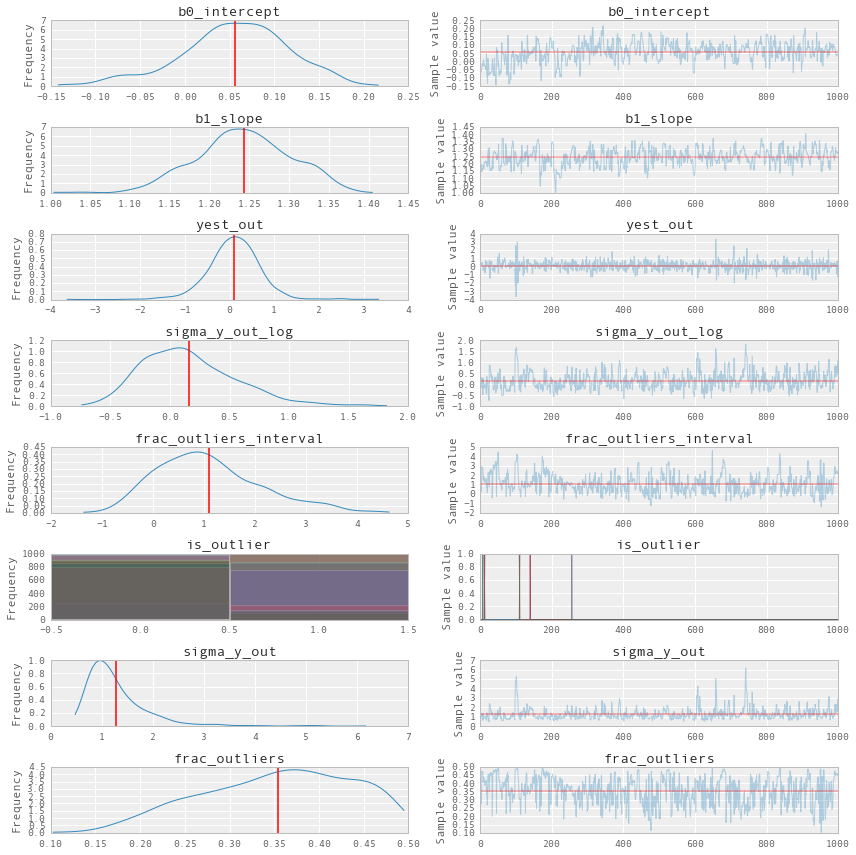

In [9]:
_ = pm.traceplot(traces_signoise[-1000:], figsize=(12,len(traces_signoise.varnames)*1.5)
            ,lines={k: v['mean'] for k, v in pm.df_summary(traces_signoise[-1000:]).iterrows()})

---

---

# Declare Outliers and Compare Plots

##### View ranges for inliers / outlier predictions

At each step of the traces, each datapoint may be either an inlier or outlier. We hope that the datapoints spend an unequal time being one state or the other, so let's take a look at the 95% credible region for each of the 20 datapoints.

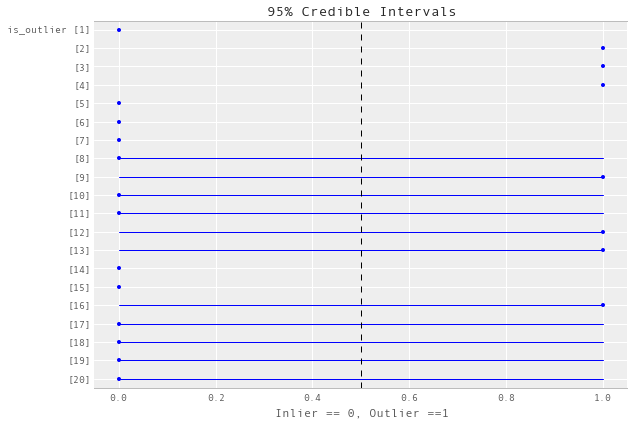

In [10]:
f = plt.figure(figsize=(10,6))
grd0 = pm.forestplot(traces_signoise[-1000:], vars=['is_outlier'], alpha=0.05
                     ,quartiles=False, vline=0.5, xtitle='Inlier == 0, Outlier ==1')

**Observe**:
+ The 95% Credible Regions indicate where each of the datapoints spend 95% of their time in the traces
+ It looks like 3 particular points spend 95% of their time as outliers
+ For comparison, the mean posterior value for `frac_outliers` is 0.35, corresponding to roughly 7 of the 20 datapoints. You can actually see these 7 datapoints on the forestplot above, all at the right hand side where x = 1. However, only 3 of these points are outliers 95% of the time. Try setting `alpha=0.2` above to see that these 7 datapoints spend 80% of their time as outliers - the 95% cutoff we choose is subjective and arbitrary.

I prefer the 95% CR cutoff for now, so let's declare these 3 to be outliers and see how it looks compared to Jake VanDer Plas' outliers, which were declared in a slightly different way as points with means above 0.68.

##### Declare outliers

**Note:**
+ I will declare outliers to be datapoints that have value == 1 at the 5-percentile cutoff, i.e. in the percentiles from 5 up to 100, their values are 1. 
+ Try for yourself altering cutoff to larger values, which leads to an objective ranking of outlier-hood.

In [11]:
cutoff = 5
dfhoggs['outlier'] = np.percentile(traces_signoise[-1000:]['is_outlier'],5, axis=0)
dfhoggs['outlier'].value_counts()

0    17
1     3
dtype: int64

## Posterior Prediction Plots for OLS vs Robust

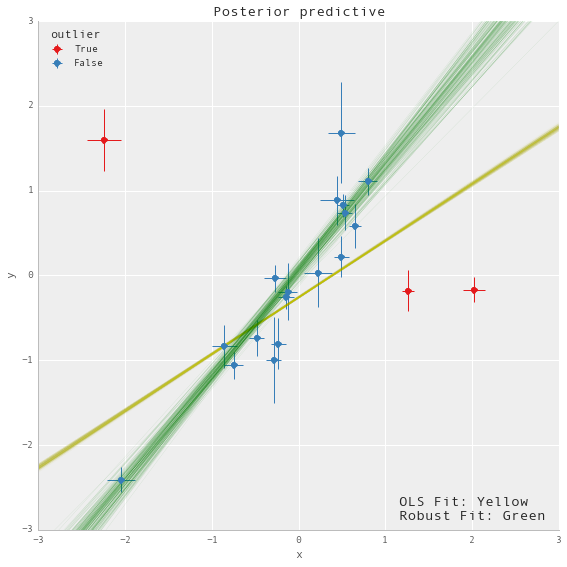

In [12]:
g = sns.FacetGrid(dfhoggs, size=8, hue='outlier', hue_order=[True,False]
                  ,palette='Set1', legend_out=False)

lm = lambda x, samp: samp['b0_intercept'] + samp['b1_slope'] * x

pm.glm.plot_posterior_predictive(traces_ols[-1000:],
        eval=np.linspace(-3, 3, 10), lm=lm, samples=200, color='y', alpha=.1)

pm.glm.plot_posterior_predictive(traces_signoise[1000:],
        eval=np.linspace(-3, 3, 10), lm=lm, samples=200, color='g', alpha=.2)

_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='').add_legend()

_ = g.axes[0][0].annotate('OLS Fit: Yellow\nRobust Fit: Green', size='x-large'
                          ,xy=(1,0), xycoords='axes fraction'
                          ,xytext=(-160,10), textcoords='offset points')
_ = g.axes[0][0].set_ylim((-3,3))

**Observe**:
+ The posterior predictive fit for the **OLS model** is shown in **Yellow** and as expected, it doesn't appear to fit the majority of our datapoints very well.
+ The posterior predictive fit for the **Robust model** is shown in **Green** does appear to fit the 'main axis' of datapoints rather well
+ We also see that the **Robust model** has estimated 3 datapoints shown in **Red** to be outliers. From even this simple inspection, the classification seems fair, and happily also agrees with Jake VanDer Plas' findings.

---